> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (Replace this with something more specific!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. In order to work with the data in this workspace, you also need to upload it to the workspace. To do so, click on the jupyter icon in the upper left to be taken back to the workspace directory. There should be an 'Upload' button in the upper right that will let you add your data file(s) to the workspace. You can then click on the .ipynb file name to come back here.

In [2]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
data = pd.read_csv('tmdb-movies.csv')

In [4]:
data.head()


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


'Homepage','id','imbd_id','tagline','overview','keywords'  has no use in analysis,so I will remove them.

Assume money is in dollars ('revenue' and 'budget').

'genres' and 'production companies' columns unfortunately  has several  values.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [6]:
data.shape


(10866, 21)


> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning 

####  1- remove 'homepage', 'tagline', 'overview', 'imdb_id','id','keywords'

####  2-check if there is duplicate

####  3-drop null  rows


#### 4-split columns with several values

#### 5-calculate profit; rev-budget

#### 6- add main star column


In [7]:
data=data.drop([ 'homepage', 'tagline', 'overview', 'imdb_id','id','keywords'], axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 15 columns):
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
director                10822 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(4), int64(5), object(6)
memory usage: 1.2+ MB


2-check if there is duplicate


In [9]:
data =data.drop_duplicates()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 15 columns):
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              10865 non-null float64
revenue_adj             10865 non-null float64
dtypes: float64(4), int64(5), object(6)
memory usage: 1.3+ MB


3-drop null  rows

In [11]:
data = data.dropna()


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 15 columns):
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
dtypes: float64(4), int64(5), object(6)
memory usage: 1.2+ MB


In [13]:
data['budget']=data['budget'].astype(float)

In [14]:
data['revenue']=data['revenue'].astype(float)

In [15]:
data['release_date'] = pd.to_datetime(data['release_date'])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 15 columns):
popularity              9772 non-null float64
budget                  9772 non-null float64
revenue                 9772 non-null float64
original_title          9772 non-null object
cast                    9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null datetime64[ns]
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3), object(5)
memory usage: 1.2+ MB


4-split columns with several values

In [17]:
data['genres'] = data['genres'].apply(lambda x: x.split('|')[0])
data['production_companies'] = data['production_companies'].apply(lambda x: x.split('|')[0])



5-calculate profit; rev-budget

In [18]:
data['profit']= data['revenue']-data['budget']

In [19]:
data.head(2)

,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
0,32.985763,150000000.0,1.513529e+09,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action,Universal Studios,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.363529e+09
1,28.419936,150000000.0,3.784364e+08,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action,Village Roadshow Pictures,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.284364e+08


6- add main star column

In [20]:
data['star'] = data['cast'].apply(lambda x: x.split('|')[0])

In [21]:
data.head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,star
0,32.985763,150000000.0,1.513529e+09,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action,Universal Studios,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.363529e+09,Chris Pratt
1,28.419936,150000000.0,3.784364e+08,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action,Village Roadshow Pictures,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.284364e+08,Tom Hardy
2,13.112507,110000000.0,2.952382e+08,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure,Summit Entertainment,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.852382e+08,Shailene Woodley
3,11.173104,200000000.0,2.068178e+09,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action,Lucasfilm,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.868178e+09,Harrison Ford
4,9.335014,190000000.0,1.506249e+09,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action,Universal Pictures,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09,1.316249e+09,Vin Diesel


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Max  profit in each genre!)











In [22]:
genres_profit =data.groupby(['genres'])['profit'].max().sort_values(ascending=False)
print (genres_profit)



genres
Action             2.544506e+09
Drama              1.645034e+09
Science Fiction    1.299558e+09
Adventure          1.202818e+09
Animation          1.124219e+09
Crime              1.084280e+09
Family             1.082731e+09
Fantasy            6.827086e+08
Comedy             6.787086e+08
Thriller           6.332399e+08
Mystery            6.328063e+08
War                4.905234e+08
Horror             4.636540e+08
Romance            4.490000e+08
Western            3.979505e+08
History            3.092209e+08
Music              2.843356e+08
Documentary        1.131145e+08
TV Movie           3.700000e+07
Foreign            0.000000e+00
Name: profit, dtype: float64


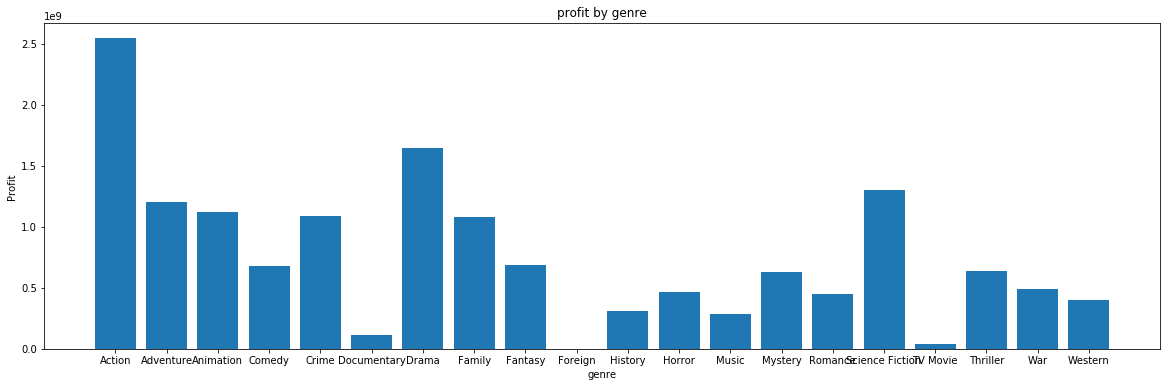

In [23]:
plt.subplots(figsize=(20, 6))
plt.bar(genres_profit.index,genres_profit)
plt.title('profit by genre')
plt.xlabel('genre')
plt.ylabel('Profit');

### Research Question 2  (total profit in each genre!)

In [24]:
genres_profit =data.groupby(['genres'])['profit'].sum().sort_values(ascending=False)
print (genres_profit)


genres
Action             5.751289e+10
Adventure          4.949608e+10
Comedy             4.396210e+10
Drama              3.644548e+10
Animation          2.012762e+10
Fantasy            1.193880e+10
Science Fiction    1.167260e+10
Horror             1.030160e+10
Crime              7.619375e+09
Thriller           7.025512e+09
Family             6.216565e+09
Romance            5.001008e+09
Mystery            1.786590e+09
War                1.361342e+09
Music              1.252416e+09
History            1.250748e+09
Documentary        6.403262e+08
Western            4.861060e+08
TV Movie           2.250000e+07
Foreign            0.000000e+00
Name: profit, dtype: float64


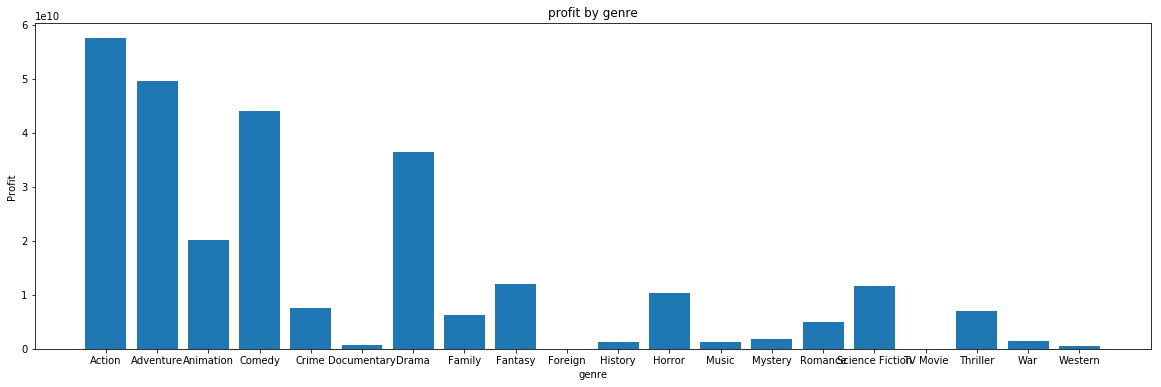

In [25]:
plt.subplots(figsize=(20, 6))
plt.bar(genres_profit.index,genres_profit)
plt.title('profit by genre')
plt.xlabel('genre')
plt.ylabel('Profit');

### Research Question 3 (Sum  profit in each company!)

In [26]:
comp_profit =data.groupby(['production_companies'])['profit'].sum().sort_values(ascending=False)
comp_profit=comp_profit.head(10)
print (comp_profit)


production_companies
Universal Pictures                        2.782093e+10
Paramount Pictures                        2.583385e+10
Walt Disney Pictures                      2.200846e+10
Columbia Pictures                         1.801072e+10
Twentieth Century Fox Film Corporation    1.641134e+10
New Line Cinema                           9.200216e+09
Lucasfilm                                 7.671385e+09
Warner Bros.                              7.478009e+09
DreamWorks SKG                            7.231459e+09
Village Roadshow Pictures                 7.073490e+09
Name: profit, dtype: float64


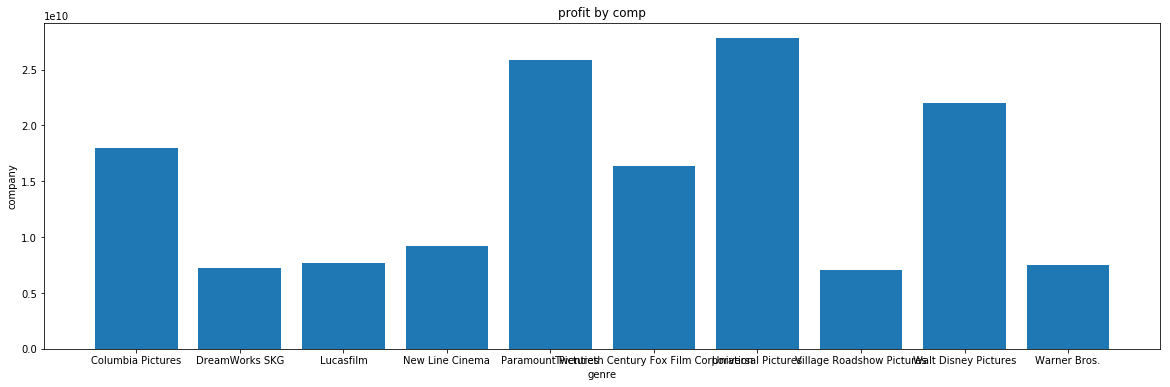

In [27]:
plt.subplots(figsize=(20, 6))
plt.bar(comp_profit.index,comp_profit)
plt.title('profit by comp')
plt.xlabel('genre')
plt.ylabel('company');

### Research Question 4 (Max  profit in each company!)

In [31]:
comp_profit =data.groupby(['production_companies'])['profit'].max().sort_values(ascending=False)
comp_profit=comp_profit.head(10)
print (comp_profit)

production_companies
Ingenious Film Partners    2.544506e+09
Lucasfilm                  1.868178e+09
Paramount Pictures         1.645034e+09
Universal Studios          1.363529e+09
Universal Pictures         1.316249e+09
Marvel Studios             1.299558e+09
Warner Bros.               1.202818e+09
Walt Disney Pictures       1.124219e+09
Columbia Pictures          1.084280e+09
WingNut Films              1.024889e+09
Name: profit, dtype: float64


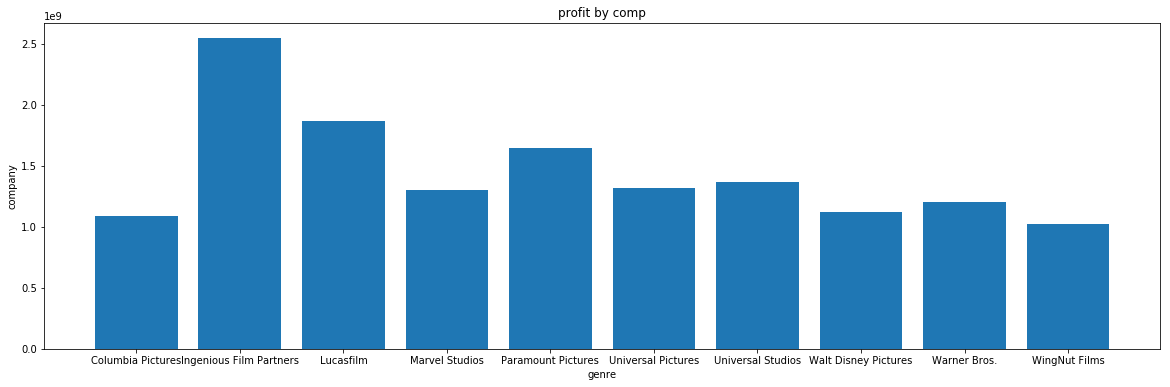

In [32]:
plt.subplots(figsize=(20, 6))
plt.bar(comp_profit.index,comp_profit)
plt.title('profit by comp')
plt.xlabel('genre')
plt.ylabel('company');


### Research Question 5 (Count cast members)

In [33]:
cast = data['cast'].str.cat(sep = '|')
cast = pd.Series(cast.split('|'))
count_cast = cast.value_counts(ascending = False)
print(count_cast.head(20))






Robert De Niro        72
Samuel L. Jackson     70
Bruce Willis          62
Nicolas Cage          61
Michael Caine         52
Robin Williams        51
Morgan Freeman        49
John Cusack           48
John Goodman          48
Susan Sarandon        47
Liam Neeson           47
Alec Baldwin          47
Tom Hanks             46
Julianne Moore        46
Dennis Quaid          45
Gene Hackman          45
Meryl Streep          44
Willem Dafoe          44
Sylvester Stallone    44
Ed Harris             43
dtype: int64


### Research Question 6  (meanin each genre!)

In [34]:

genres_profit =data.groupby(['genres'])['profit'].mean().sort_values(ascending=False)
print (genres_profit)


genres
Adventure          8.999286e+07
Science Fiction    5.955409e+07
Animation          5.817231e+07
Family             4.856691e+07
Fantasy            4.718895e+07
Action             3.888634e+07
History            3.207047e+07
Romance            3.106216e+07
War                2.388319e+07
Crime              2.110630e+07
Comedy             2.109506e+07
Drama              1.639473e+07
Music              1.585337e+07
Mystery            1.514059e+07
Thriller           1.482176e+07
Horror             1.207691e+07
Western            1.157395e+07
Documentary        2.425478e+06
TV Movie           3.813559e+05
Foreign            0.000000e+00
Name: profit, dtype: float64


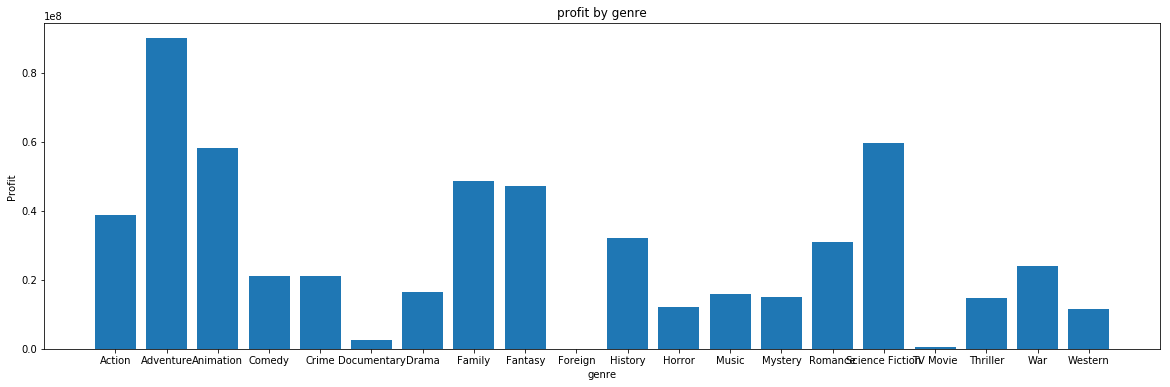

In [35]:
plt.subplots(figsize=(20, 6))
plt.bar(genres_profit.index,genres_profit)
plt.title('profit by genre')
plt.xlabel('genre')
plt.ylabel('Profit');

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

# My Conclusion

### Action movies has max profit in the list
### Adventure movies has greatest mean
### Robert De Niro participed in 72 movie (highest number of  participation)




In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])